In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nivlink import ScreenInfo, to_features, compute_fixations
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

/Users/szoro/Documents/software/anaconda3.6/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/szoro/Documents/software/anaconda3.6/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Extract Sample Data

In [2]:
from pandas import DataFrame
from loadmat import loadmat

## Main loop.
for subj in [2,4]:

    ## Load matlab data.
    mat = loadmat('sample/2.mat')
    
    ## Preallocate space.
    df = DataFrame([], columns=('Run','StimTime'))
    
    for i, run in enumerate(mat['Data']):

        ## Extract stimulus onsets.
        stimulus_onsets = run['StimOn']
        
        ## Append to DataFrame.
        df = df.append(DataFrame(np.vstack([np.ones_like(stimulus_onsets) * (i+1), stimulus_onsets]).T, 
                                 columns=('Run','StimTime')), sort=False)
        
    ## Add subject info.
    df.insert(0,'Subject',subj)
    
    ## Save.
    df.to_csv('sample/%s.csv' %subj, index=False)

/Users/szoro/Documents/software/anaconda3.6/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Testing Screen Info
Tutorial for adding new shapes [maybe](https://nickcharlton.net/posts/drawing-animating-shapes-matplotlib.html)

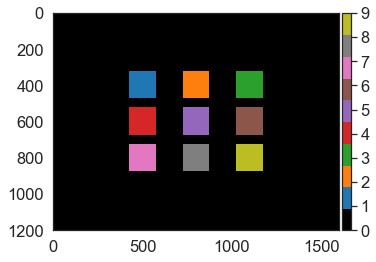

In [3]:
from itertools import product

## Initialize object.
info = ScreenInfo(1600,1200,500)

## Add AOIs.
xpos = [425,725,1025]
ypos = [325,525,725]
xwidth = ywidth = 150
    
for i, (ymin, xmin) in enumerate(product(ypos, xpos)):
    info.add_rectangle_aoi(i+1, xmin, xmin+xwidth, ymin, ymin+ywidth)

## Visualize.
info.plot_screen(height=4,ticks=True);

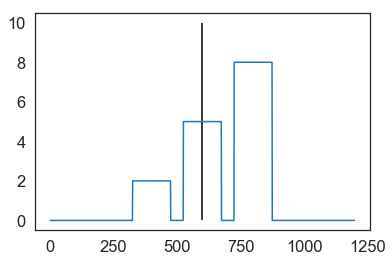

In [13]:
plt.plot(info.indices[800])
plt.vlines(600,0,10)

## Epoching

In [ ]:
from pandas import read_csv

## Define metadata.
n_runs = 6
trial_length = 4

## Define subject info.
behavior = read_csv('sample/2.csv')
eyetrack = read_csv('sample/2raw.txt', sep='\t', usecols=['SAMPLE_MESSAGE','RIGHT_GAZE_X','RIGHT_GAZE_Y'])

## Preprocessing.
eyetrack[['RIGHT_GAZE_X','RIGHT_GAZE_Y']] = eyetrack[['RIGHT_GAZE_X','RIGHT_GAZE_Y']].replace('.',np.nan).astype(float)

## Define times.
sfreq = 500
times = np.arange(0, eyetrack.shape[0] / sfreq, 1 / sfreq)

## Define block starts.
template = 'Start of Run%s'
block_starts = np.zeros_like(times)
block_starts[[(eyetrack.SAMPLE_MESSAGE==template %i).values.argmax() for i in np.arange(n_runs)+1]] = np.arange(n_runs)+1

## Modify trial starts by block offsets.
for i, offset in enumerate(times[block_starts.nonzero()]):
    behavior.loc[behavior.Run==i+1, 'StimTime'] += offset

## Epoching.
stim_indices = np.array([np.argmax(times > t) for t in behavior.StimTime])

epochs = np.array([eyetrack.loc[i:i + sfreq*trial_length, ['RIGHT_GAZE_X','RIGHT_GAZE_Y']].values for i in stim_indices])

## Feature Assignment

In [ ]:
%timeit ts_feat = to_features(epochs, info)
ts_feat = to_features(epochs, info)

## Clustering

In [ ]:
%timeit compute_fixations(ts_feat, info.sfreq, info.features)
fixations = compute_fixations(ts_feat, info.sfreq, info.features)

In [ ]:
## Plot summary statistics.
fig, axes = plt.subplots(1,2,figsize=(10,4))
sns.distplot(fixations.groupby('Trial').Duration.sum(), kde=False, ax=axes[0])
sns.distplot(fixations.Duration, kde=False, ax=axes[1])
sns.despine()
plt.tight_layout()

In [ ]:
plt.hist(fixations.Duration, np.)

In [ ]:
plt.hist(fixations.Duration, np.logspace(-3,0,100))
plt.xscale('log')

In [ ]:
fixations